# MLP Gating Mechanisms and Stochastic Depth

Изучаем GLU блоки, Gated Residual и DropPath для глубоких MLP сетей.

Данные: Wine Quality (мультиклассовая классификация)

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style('whitegrid')
set_seed(42)

## Базовые классы

In [2]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim or dim
        self.activation = {'relu': nn.ReLU(), 'gelu': nn.GELU(), 'swish': nn.SiLU()}.get(activation, nn.GELU())
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    @abstractmethod
    def forward(self, x): pass

class DeepMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, block_class, block_kwargs=None):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([block_class(dim=hidden_dim, **(block_kwargs or {})) for _ in range(num_blocks)])
        self.output_proj = nn.Linear(hidden_dim, output_dim)
        self.output_dim = output_dim
    def forward(self, x):
        x = self.input_proj(x)
        for block in self.blocks: x = block(x)
        return self.output_proj(x)

print('OK')

OK


## GLU и Gated Residual блоки

1. GLU: y = φ(Wx) ⊙ σ(Vx)
2. GLU Residual: y = x + GLU(x)
3. Gated Residual: y = x + g(x) ⊙ F(x)

In [3]:
class SimpleResidualBlock(BaseMLPBlock):
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.fc1 = nn.Linear(self.dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.dim)
    def forward(self, x):
        res = self.fc2(self.activation(self.fc1(x)))
        return x + (self.dropout(res) if self.dropout else res)

class GLUBlock(BaseMLPBlock):
    def __init__(self, dim, hidden_dim=None, activation='gelu', gate_activation='sigmoid', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.linear_main = nn.Linear(self.dim, self.hidden_dim)
        self.linear_gate = nn.Linear(self.dim, self.hidden_dim)
        self.gate_act = nn.Sigmoid() if gate_activation == 'sigmoid' else nn.SiLU()
        self.out_proj = nn.Linear(self.hidden_dim, self.dim) if self.hidden_dim != self.dim else None
    def forward(self, x):
        out = self.activation(self.linear_main(x)) * self.gate_act(self.linear_gate(x))
        if self.dropout: out = self.dropout(out)
        if self.out_proj: out = self.out_proj(out)
        return out

class GLUResidualBlock(BaseMLPBlock):
    def __init__(self, dim, hidden_dim=None, activation='gelu', gate_activation='sigmoid', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.glu = GLUBlock(dim, hidden_dim, activation, gate_activation, dropout)
    def forward(self, x): return x + self.glu(x)

class GatedResidualBlock(BaseMLPBlock):
    def __init__(self, dim, hidden_dim=None, activation='gelu', gate_activation='sigmoid', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.fc1, self.fc2 = nn.Linear(self.dim, self.hidden_dim), nn.Linear(self.hidden_dim, self.dim)
        self.gate = nn.Linear(self.dim, self.dim)
        self.gate_act = nn.Sigmoid() if gate_activation == 'sigmoid' else nn.SiLU()
    def forward(self, x):
        res = self.fc2(self.activation(self.fc1(x)))
        if self.dropout: res = self.dropout(res)
        return x + self.gate_act(self.gate(x)) * res

print('Блоки созданы!')

Блоки созданы!


## Stochastic Depth (DropPath)

Per-sample dropout для residual блоков. Расписание: drop_prob[l] = drop_max * l / (n-1)

In [4]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = drop_prob
    def forward(self, x):
        if self.drop_prob == 0 or not self.training: return x
        keep = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        mask = (keep + torch.rand(shape, dtype=x.dtype, device=x.device)).floor_()
        return x.div(keep) * mask

class ResidualBlockWithDropPath(BaseMLPBlock):
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0, drop_path_prob=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.fc1, self.fc2 = nn.Linear(self.dim, self.hidden_dim), nn.Linear(self.hidden_dim, self.dim)
        self.drop_path = DropPath(drop_path_prob)
    def forward(self, x):
        res = self.fc2(self.activation(self.fc1(x)))
        if self.dropout: res = self.dropout(res)
        return x + self.drop_path(res)

class DeepMLPWithDropPath(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_blocks, block_class=ResidualBlockWithDropPath, drop_path_max=0.0, block_kwargs=None):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        drop_probs = [drop_path_max * i / (num_blocks - 1) for i in range(num_blocks)] if num_blocks > 1 else [0.0]
        self.blocks = nn.ModuleList([block_class(dim=hidden_dim, drop_path_prob=drop_probs[i], **(block_kwargs or {})) for i in range(num_blocks)])
        self.output_proj = nn.Linear(hidden_dim, output_dim)
        self.output_dim, self.drop_probs = output_dim, drop_probs
    def forward(self, x):
        x = self.input_proj(x)
        for b in self.blocks: x = b(x)
        return self.output_proj(x)

print('DropPath готов!')

DropPath готов!


## Данные

In [5]:
dm = WineQualityDataModule(batch_size=128)
dm.setup()
print(f'Train: {len(dm.train_dataset)}, Val: {len(dm.val_dataset)}')
print(f'Input dim: {dm.input_dim}, Classes: {dm.n_classes}')

Train: 1279, Val: 320
Input dim: 11, Classes: 6


## Обучение

In [6]:
def train_model(model, name, max_epochs=50):
    lm = BaseLightningModule(model=model, loss_fn=nn.CrossEntropyLoss(), optimizer_type='adam', learning_rate=1e-3, task_type='multiclass')
    trainer = Trainer(max_epochs=max_epochs, enable_checkpointing=False, logger=False, enable_progress_bar=True, enable_model_summary=False)
    trainer.fit(lm, dm)
    m = trainer.callback_metrics
    return {'name': name, 'val_acc': m.get('val_accuracy', 0).item() if 'val_accuracy' in m else 0, 'val_f1': m.get('val_f1_macro', 0).item() if 'val_f1_macro' in m else 0}

print('OK')

OK


## Эксперименты

Сравниваем 5 архитектур на глубинах 2, 6, 12, 18, 24

In [7]:
hidden_dim, depths, results = 128, [2, 6, 12, 18, 24], []

for depth in depths:
    print(f'\n=== Depth {depth} ===')
    bkw = {'hidden_dim': hidden_dim*2, 'activation': 'gelu', 'dropout': 0.1}
    
    # 1. Simple Residual
    print('[1/5] SimpleResidual')
    m = DeepMLP(dm.input_dim, hidden_dim, dm.n_classes, depth, SimpleResidualBlock, bkw)
    r = train_model(m, f'SimpleRes_d{depth}', 50)
    r.update({'depth': depth, 'type': 'SimpleRes'})
    results.append(r)
    print(f"Acc: {r['val_acc']:.4f}, F1: {r['val_f1']:.4f}")
    
    # 2. GLU
    print('[2/5] GLU')
    m = DeepMLP(dm.input_dim, hidden_dim, dm.n_classes, depth, GLUBlock, bkw)
    r = train_model(m, f'GLU_d{depth}', 50)
    r.update({'depth': depth, 'type': 'GLU'})
    results.append(r)
    print(f"Acc: {r['val_acc']:.4f}, F1: {r['val_f1']:.4f}")
    
    # 3. GLU Residual
    print('[3/5] GLUResidual')
    m = DeepMLP(dm.input_dim, hidden_dim, dm.n_classes, depth, GLUResidualBlock, bkw)
    r = train_model(m, f'GLURes_d{depth}', 50)
    r.update({'depth': depth, 'type': 'GLURes'})
    results.append(r)
    print(f"Acc: {r['val_acc']:.4f}, F1: {r['val_f1']:.4f}")
    
    # 4. Gated Residual
    print('[4/5] GatedResidual')
    m = DeepMLP(dm.input_dim, hidden_dim, dm.n_classes, depth, GatedResidualBlock, bkw)
    r = train_model(m, f'GatedRes_d{depth}', 50)
    r.update({'depth': depth, 'type': 'GatedRes'})
    results.append(r)
    print(f"Acc: {r['val_acc']:.4f}, F1: {r['val_f1']:.4f}")
    
    # 5. Residual + DropPath
    print('[5/5] ResDropPath')
    m = DeepMLPWithDropPath(dm.input_dim, hidden_dim, dm.n_classes, depth, ResidualBlockWithDropPath, 0.3, bkw)
    r = train_model(m, f'ResDP_d{depth}', 50)
    r.update({'depth': depth, 'type': 'ResDP'})
    results.append(r)
    print(f"Acc: {r['val_acc']:.4f}, F1: {r['val_f1']:.4f}")

print('\nВсе эксперименты завершены!')

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Depth 2 ===
[1/5] SimpleResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0938, f1_macro=0.0655


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3542, f1_macro=0.1758


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4431, f1_macro=0.2458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4811, f1_macro=0.2527


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5039, f1_macro=0.2618


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5194, f1_macro=0.2674


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5317, f1_macro=0.2746


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5401, f1_macro=0.2765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5487, f1_macro=0.2816


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5533, f1_macro=0.2828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5570, f1_macro=0.2860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5606, f1_macro=0.2866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5640, f1_macro=0.2882


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5661, f1_macro=0.2885


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5686, f1_macro=0.2894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5706, f1_macro=0.2900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5740, f1_macro=0.2919


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5764, f1_macro=0.2927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5775, f1_macro=0.2933


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5788, f1_macro=0.2936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5795, f1_macro=0.2940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5807, f1_macro=0.2940


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5822, f1_macro=0.2950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5830, f1_macro=0.2949


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5843, f1_macro=0.2955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5859, f1_macro=0.2957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5871, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5876, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5880, f1_macro=0.2960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5883, f1_macro=0.2965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5884, f1_macro=0.2960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5888, f1_macro=0.2964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5899, f1_macro=0.2970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5901, f1_macro=0.2968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5902, f1_macro=0.2968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5902, f1_macro=0.2977


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5909, f1_macro=0.2976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5914, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5913, f1_macro=0.2980


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5923, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5926, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5923, f1_macro=0.2985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5923, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5919, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5924, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5930, f1_macro=0.2991


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5926, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5924, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5925, f1_macro=0.2984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5929, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.5930, f1_macro=0.2987
Acc: 0.5930, F1: 0.2987
[2/5] GLU


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0352, f1_macro=0.0113


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2517, f1_macro=0.0914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.3560, f1_macro=0.1541


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4153, f1_macro=0.1858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.4557, f1_macro=0.2168


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.4795, f1_macro=0.2290


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.4959, f1_macro=0.2412


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5100, f1_macro=0.2485


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5195, f1_macro=0.2559


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5268, f1_macro=0.2579


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5356, f1_macro=0.2633


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5424, f1_macro=0.2683


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5479, f1_macro=0.2701


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5516, f1_macro=0.2722


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5545, f1_macro=0.2733


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5566, f1_macro=0.2747


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5595, f1_macro=0.2754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5620, f1_macro=0.2764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5643, f1_macro=0.2776


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5666, f1_macro=0.2774


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5682, f1_macro=0.2797


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5698, f1_macro=0.2805


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5715, f1_macro=0.2819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5738, f1_macro=0.2843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5755, f1_macro=0.2853


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5776, f1_macro=0.2871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5784, f1_macro=0.2880


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5803, f1_macro=0.2898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5815, f1_macro=0.2909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5831, f1_macro=0.2921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5845, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5858, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5873, f1_macro=0.2955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5889, f1_macro=0.2967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5904, f1_macro=0.2980


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5910, f1_macro=0.2980


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5922, f1_macro=0.2989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5928, f1_macro=0.2997


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5941, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5954, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5963, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5964, f1_macro=0.3012


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5975, f1_macro=0.3020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5980, f1_macro=0.3026


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5991, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5998, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.6002, f1_macro=0.3046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.6007, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.6012, f1_macro=0.3058


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.6019, f1_macro=0.3064


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.6024, f1_macro=0.3064
Acc: 0.6024, F1: 0.3064
[3/5] GLUResidual


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3984, f1_macro=0.2335


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4740, f1_macro=0.2361


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.5234, f1_macro=0.2675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5444, f1_macro=0.2785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5560, f1_macro=0.2803


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5636, f1_macro=0.2813


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5703, f1_macro=0.2836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5741, f1_macro=0.2854


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5767, f1_macro=0.2856


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5788, f1_macro=0.2860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5819, f1_macro=0.2876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5842, f1_macro=0.2877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5850, f1_macro=0.2886


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5856, f1_macro=0.2903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5868, f1_macro=0.2903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5888, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5887, f1_macro=0.2925


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5902, f1_macro=0.2931


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5904, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5915, f1_macro=0.2935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5924, f1_macro=0.2953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5920, f1_macro=0.2955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5931, f1_macro=0.2958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5945, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5954, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5951, f1_macro=0.2996


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5950, f1_macro=0.2995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5955, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5951, f1_macro=0.3012


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5954, f1_macro=0.3018


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5959, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5963, f1_macro=0.3018


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5963, f1_macro=0.3034


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5967, f1_macro=0.3035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5966, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5965, f1_macro=0.3029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5966, f1_macro=0.3033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5971, f1_macro=0.3036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5976, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5980, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5977, f1_macro=0.3040


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5979, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5983, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5980, f1_macro=0.3039


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5988, f1_macro=0.3043


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5994, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.6002, f1_macro=0.3049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.6004, f1_macro=0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.6002, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5997, f1_macro=0.3052


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.6003, f1_macro=0.3054
Acc: 0.6003, F1: 0.3054
[4/5] GatedResidual


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2188, f1_macro=0.1163


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4097, f1_macro=0.1892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4799, f1_macro=0.2404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5107, f1_macro=0.2612


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5293, f1_macro=0.2678


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5388, f1_macro=0.2718


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5478, f1_macro=0.2766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5521, f1_macro=0.2775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5597, f1_macro=0.2810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5641, f1_macro=0.2834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5677, f1_macro=0.2853


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5699, f1_macro=0.2858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5732, f1_macro=0.2864


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5750, f1_macro=0.2874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5754, f1_macro=0.2867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5777, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5791, f1_macro=0.2891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5799, f1_macro=0.2884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5806, f1_macro=0.2886


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5814, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5826, f1_macro=0.2883


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5834, f1_macro=0.2896


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5843, f1_macro=0.2899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5846, f1_macro=0.2899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5862, f1_macro=0.2903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5865, f1_macro=0.2907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5875, f1_macro=0.2909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5879, f1_macro=0.2908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5889, f1_macro=0.2918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5896, f1_macro=0.2923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5897, f1_macro=0.2927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5906, f1_macro=0.2938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5915, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5921, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5925, f1_macro=0.2950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5939, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5944, f1_macro=0.2969


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5946, f1_macro=0.2970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5950, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5953, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5973, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5976, f1_macro=0.3011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5988, f1_macro=0.3021


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5992, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5994, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5996, f1_macro=0.3040


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5998, f1_macro=0.3044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.6002, f1_macro=0.3047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.6001, f1_macro=0.3059


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.6005, f1_macro=0.3063


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.6008, f1_macro=0.3068
Acc: 0.6008, F1: 0.3068
[5/5] ResDropPath


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1992, f1_macro=0.1381


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4062, f1_macro=0.2121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4788, f1_macro=0.2638


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5025, f1_macro=0.2602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5228, f1_macro=0.2684


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5350, f1_macro=0.2717


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5450, f1_macro=0.2741


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5521, f1_macro=0.2773


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5558, f1_macro=0.2764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5606, f1_macro=0.2787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5663, f1_macro=0.2824


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5694, f1_macro=0.2834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5728, f1_macro=0.2849


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5745, f1_macro=0.2852


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5769, f1_macro=0.2860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5785, f1_macro=0.2869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5798, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5815, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5834, f1_macro=0.2894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5848, f1_macro=0.2896


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5859, f1_macro=0.2900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5874, f1_macro=0.2910


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5881, f1_macro=0.2914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5894, f1_macro=0.2924


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5901, f1_macro=0.2922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5914, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5918, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5927, f1_macro=0.2939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5933, f1_macro=0.2939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5943, f1_macro=0.2943


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5950, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5952, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5956, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5957, f1_macro=0.2952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5960, f1_macro=0.2958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5970, f1_macro=0.2965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5971, f1_macro=0.2978


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5981, f1_macro=0.2985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5991, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5996, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.6003, f1_macro=0.3013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.6013, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.6025, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.6029, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.6034, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.6038, f1_macro=0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.6047, f1_macro=0.3065


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.6055, f1_macro=0.3079


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.6060, f1_macro=0.3082


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.6070, f1_macro=0.3095


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.6072, f1_macro=0.3097
Acc: 0.6072, F1: 0.3097

=== Depth 6 ===
[1/5] SimpleResidual


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1172, f1_macro=0.0595


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3837, f1_macro=0.2264


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4576, f1_macro=0.2473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5000, f1_macro=0.2664


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5234, f1_macro=0.2730


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5388, f1_macro=0.2798


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5473, f1_macro=0.2826


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5545, f1_macro=0.2831


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5607, f1_macro=0.2852


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5631, f1_macro=0.2869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5660, f1_macro=0.2891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5689, f1_macro=0.2894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5725, f1_macro=0.2906


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5734, f1_macro=0.2908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5750, f1_macro=0.2899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5765, f1_macro=0.2916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5794, f1_macro=0.2947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5788, f1_macro=0.2939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5801, f1_macro=0.2950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5797, f1_macro=0.2945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5807, f1_macro=0.2954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5817, f1_macro=0.2947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5818, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5832, f1_macro=0.2950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5833, f1_macro=0.2949


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5841, f1_macro=0.2956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5862, f1_macro=0.2969


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5848, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5854, f1_macro=0.2964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5861, f1_macro=0.2966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5858, f1_macro=0.2966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5863, f1_macro=0.2967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5860, f1_macro=0.2965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5864, f1_macro=0.2968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5868, f1_macro=0.2969


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5881, f1_macro=0.2974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5892, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5889, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5889, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5886, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5898, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5902, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5902, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5908, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5907, f1_macro=0.2998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5907, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5911, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5909, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5907, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5915, f1_macro=0.3020


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.5917, f1_macro=0.3029


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Acc: 0.5917, F1: 0.3029
[2/5] GLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1367, f1_macro=0.0401


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2969, f1_macro=0.1155


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.3337, f1_macro=0.1594


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.3577, f1_macro=0.1599


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.3815, f1_macro=0.1700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.4030, f1_macro=0.1758


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.4246, f1_macro=0.1817


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.4367, f1_macro=0.1842


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.4499, f1_macro=0.1875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.4608, f1_macro=0.1902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.4679, f1_macro=0.1916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.4764, f1_macro=0.1936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.4846, f1_macro=0.1957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.4937, f1_macro=0.2042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5013, f1_macro=0.2102


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5067, f1_macro=0.2161


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5106, f1_macro=0.2163


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5151, f1_macro=0.2206


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5206, f1_macro=0.2241


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5256, f1_macro=0.2278


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5288, f1_macro=0.2315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5323, f1_macro=0.2338


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5362, f1_macro=0.2367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5395, f1_macro=0.2392


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5436, f1_macro=0.2432


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5474, f1_macro=0.2467


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5498, f1_macro=0.2489


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5525, f1_macro=0.2519


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5546, f1_macro=0.2531


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5565, f1_macro=0.2552


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5583, f1_macro=0.2564


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5603, f1_macro=0.2574


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5635, f1_macro=0.2605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5643, f1_macro=0.2622


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5663, f1_macro=0.2630


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5677, f1_macro=0.2639


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5689, f1_macro=0.2647


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5699, f1_macro=0.2662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5720, f1_macro=0.2681


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5736, f1_macro=0.2693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5748, f1_macro=0.2704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5756, f1_macro=0.2713


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5770, f1_macro=0.2723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5782, f1_macro=0.2733


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5799, f1_macro=0.2749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5812, f1_macro=0.2763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5817, f1_macro=0.2770


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5824, f1_macro=0.2777


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5837, f1_macro=0.2787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5848, f1_macro=0.2798


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5859, f1_macro=0.2804
Acc: 0.5859, F1: 0.2804
[3/5] GLUResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2930, f1_macro=0.1652


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4688, f1_macro=0.2346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.5100, f1_macro=0.2639


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5312, f1_macro=0.2691


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5482, f1_macro=0.2735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5555, f1_macro=0.2761


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5630, f1_macro=0.2780


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5673, f1_macro=0.2806


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5703, f1_macro=0.2833


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5724, f1_macro=0.2838


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5758, f1_macro=0.2858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5787, f1_macro=0.2862


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5801, f1_macro=0.2860


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5815, f1_macro=0.2870


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5823, f1_macro=0.2869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5821, f1_macro=0.2865


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5839, f1_macro=0.2876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5843, f1_macro=0.2868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5856, f1_macro=0.2878


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5876, f1_macro=0.2914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5871, f1_macro=0.2929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5890, f1_macro=0.2938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5884, f1_macro=0.2923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5893, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5892, f1_macro=0.2929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5900, f1_macro=0.2942


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5919, f1_macro=0.2953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5916, f1_macro=0.2957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5918, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5929, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5936, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5938, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5937, f1_macro=0.2992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5940, f1_macro=0.2995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5944, f1_macro=0.2997


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5954, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5961, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5971, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5971, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5974, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5977, f1_macro=0.3033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5981, f1_macro=0.3033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5988, f1_macro=0.3036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5991, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5994, f1_macro=0.3043


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5998, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.6000, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.6002, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.6002, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.6006, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.6009, f1_macro=0.3069
Acc: 0.6009, F1: 0.3069
[4/5] GatedResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1445, f1_macro=0.1272


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3872, f1_macro=0.2337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4654, f1_macro=0.2693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5008, f1_macro=0.2815


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5208, f1_macro=0.2816


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5350, f1_macro=0.2903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5441, f1_macro=0.2931


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5537, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5604, f1_macro=0.2959


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5638, f1_macro=0.2964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5677, f1_macro=0.2982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5712, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5720, f1_macro=0.2973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5745, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5762, f1_macro=0.2972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5785, f1_macro=0.2978


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5796, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5802, f1_macro=0.2976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5826, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5844, f1_macro=0.2985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5862, f1_macro=0.2985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5876, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5876, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5869, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5880, f1_macro=0.2994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5885, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5894, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5915, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5919, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5929, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5925, f1_macro=0.3029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5918, f1_macro=0.3020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5929, f1_macro=0.3026


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5932, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5938, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5937, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5943, f1_macro=0.3034


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5947, f1_macro=0.3039


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5942, f1_macro=0.3035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5946, f1_macro=0.3036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5949, f1_macro=0.3039


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5956, f1_macro=0.3047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5962, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5965, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5971, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5962, f1_macro=0.3052


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5968, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5965, f1_macro=0.3065


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5971, f1_macro=0.3069


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5971, f1_macro=0.3080


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5965, f1_macro=0.3092
Acc: 0.5965, F1: 0.3092
[5/5] ResDropPath


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1094, f1_macro=0.0792


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3646, f1_macro=0.2054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4342, f1_macro=0.2153


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4794, f1_macro=0.2421


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5033, f1_macro=0.2509


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5226, f1_macro=0.2644


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5331, f1_macro=0.2647


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5413, f1_macro=0.2664


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5490, f1_macro=0.2711


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5548, f1_macro=0.2742


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5590, f1_macro=0.2753


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5625, f1_macro=0.2772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5659, f1_macro=0.2804


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5697, f1_macro=0.2828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5722, f1_macro=0.2844


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5754, f1_macro=0.2863


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5785, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5813, f1_macro=0.2894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5821, f1_macro=0.2888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5824, f1_macro=0.2909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5819, f1_macro=0.2905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5830, f1_macro=0.2903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5846, f1_macro=0.2911


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5840, f1_macro=0.2922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5846, f1_macro=0.2943


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5865, f1_macro=0.2964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5871, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5887, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5900, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5895, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5899, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5907, f1_macro=0.3037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5903, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5914, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5931, f1_macro=0.3062


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5935, f1_macro=0.3059


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5933, f1_macro=0.3059


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5937, f1_macro=0.3068


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5941, f1_macro=0.3075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5947, f1_macro=0.3078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5945, f1_macro=0.3080


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5953, f1_macro=0.3088


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5961, f1_macro=0.3094


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5965, f1_macro=0.3100


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5972, f1_macro=0.3102


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5978, f1_macro=0.3107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5984, f1_macro=0.3109


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5988, f1_macro=0.3112


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5989, f1_macro=0.3117


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5991, f1_macro=0.3119


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.5992, f1_macro=0.3121


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Acc: 0.5992, F1: 0.3121

=== Depth 12 ===
[1/5] SimpleResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2500, f1_macro=0.1405


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3941, f1_macro=0.2035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4654, f1_macro=0.2332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4975, f1_macro=0.2506


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5169, f1_macro=0.2613


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5302, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5395, f1_macro=0.2713


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5445, f1_macro=0.2723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5504, f1_macro=0.2766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5558, f1_macro=0.2787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5582, f1_macro=0.2810


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5622, f1_macro=0.2824


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5649, f1_macro=0.2823


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5668, f1_macro=0.2836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5684, f1_macro=0.2844


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5694, f1_macro=0.2864


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5696, f1_macro=0.2866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5699, f1_macro=0.2857


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5725, f1_macro=0.2872


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5735, f1_macro=0.2874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5747, f1_macro=0.2891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5757, f1_macro=0.2904


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5772, f1_macro=0.2918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5781, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5777, f1_macro=0.2937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5778, f1_macro=0.2937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5789, f1_macro=0.2947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5775, f1_macro=0.2947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5778, f1_macro=0.2952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5789, f1_macro=0.2964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5788, f1_macro=0.2967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5797, f1_macro=0.2981


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5802, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5809, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5814, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5819, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5819, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5822, f1_macro=0.3055


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5822, f1_macro=0.3063


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5824, f1_macro=0.3070


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5831, f1_macro=0.3075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5835, f1_macro=0.3088


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5839, f1_macro=0.3104


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5842, f1_macro=0.3106


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5849, f1_macro=0.3122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5859, f1_macro=0.3148


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5873, f1_macro=0.3168


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5879, f1_macro=0.3175


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5879, f1_macro=0.3186


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5891, f1_macro=0.3206


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5901, f1_macro=0.3226
Acc: 0.5901, F1: 0.3226
[2/5] GLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4258, f1_macro=0.0995


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4253, f1_macro=0.0995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4252, f1_macro=0.0995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4252, f1_macro=0.0994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.4251, f1_macro=0.0994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.4251, f1_macro=0.0994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.4214, f1_macro=0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.4219, f1_macro=0.1277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.4222, f1_macro=0.1254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.4225, f1_macro=0.1233


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.4227, f1_macro=0.1216


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.4208, f1_macro=0.1335


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.4211, f1_macro=0.1317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.4214, f1_macro=0.1302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.4217, f1_macro=0.1287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.4219, f1_macro=0.1274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.4206, f1_macro=0.1346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.4208, f1_macro=0.1333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.4197, f1_macro=0.1384


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.4200, f1_macro=0.1372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.4202, f1_macro=0.1362


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.4204, f1_macro=0.1352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.4206, f1_macro=0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.4208, f1_macro=0.1333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.4210, f1_macro=0.1324


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.4211, f1_macro=0.1315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.4204, f1_macro=0.1355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.4205, f1_macro=0.1347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.4207, f1_macro=0.1339


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.4208, f1_macro=0.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.4210, f1_macro=0.1325


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4211, f1_macro=0.1318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4212, f1_macro=0.1312


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4213, f1_macro=0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4207, f1_macro=0.1338


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4208, f1_macro=0.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4203, f1_macro=0.1359


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4204, f1_macro=0.1353


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4205, f1_macro=0.1348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4206, f1_macro=0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4207, f1_macro=0.1337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4208, f1_macro=0.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4203, f1_macro=0.1355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4204, f1_macro=0.1350


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4205, f1_macro=0.1345


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4206, f1_macro=0.1341


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4207, f1_macro=0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4208, f1_macro=0.1331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4209, f1_macro=0.1327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4210, f1_macro=0.1323


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.4211, f1_macro=0.1319
Acc: 0.4211, F1: 0.1319
[3/5] GLUResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0977, f1_macro=0.0581


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3628, f1_macro=0.1735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4431, f1_macro=0.2056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4885, f1_macro=0.2326


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5085, f1_macro=0.2404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5253, f1_macro=0.2530


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5404, f1_macro=0.2626


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5501, f1_macro=0.2653


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5558, f1_macro=0.2697


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5584, f1_macro=0.2707


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5628, f1_macro=0.2736


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5670, f1_macro=0.2769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5693, f1_macro=0.2785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5711, f1_macro=0.2790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5731, f1_macro=0.2809


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5742, f1_macro=0.2818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5742, f1_macro=0.2816


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5757, f1_macro=0.2822


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5765, f1_macro=0.2827


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5773, f1_macro=0.2848


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5790, f1_macro=0.2846


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5803, f1_macro=0.2863


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5814, f1_macro=0.2869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5817, f1_macro=0.2880


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5832, f1_macro=0.2901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5843, f1_macro=0.2908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5849, f1_macro=0.2912


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5858, f1_macro=0.2924


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5879, f1_macro=0.2943


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5887, f1_macro=0.2948


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5887, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5887, f1_macro=0.2945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5893, f1_macro=0.2953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5894, f1_macro=0.2960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5904, f1_macro=0.2965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5903, f1_macro=0.2969


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5909, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5907, f1_macro=0.2984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5904, f1_macro=0.2984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5903, f1_macro=0.2982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5896, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5896, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5901, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5900, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5901, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5899, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5901, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5900, f1_macro=0.3015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5898, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5909, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.5910, f1_macro=0.3057
Acc: 0.5910, F1: 0.3057
[4/5] GatedResidual


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1836, f1_macro=0.1137


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4080, f1_macro=0.2169


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4710, f1_macro=0.2427


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4984, f1_macro=0.2414


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5163, f1_macro=0.2518


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5302, f1_macro=0.2597


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5409, f1_macro=0.2627


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5497, f1_macro=0.2677


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5554, f1_macro=0.2712


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5609, f1_macro=0.2731


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5634, f1_macro=0.2725


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5667, f1_macro=0.2760


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5696, f1_macro=0.2772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5720, f1_macro=0.2793


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5724, f1_macro=0.2792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5728, f1_macro=0.2793


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5731, f1_macro=0.2818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5741, f1_macro=0.2819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5755, f1_macro=0.2851


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5769, f1_macro=0.2849


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5795, f1_macro=0.2868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5803, f1_macro=0.2873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5825, f1_macro=0.2895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5839, f1_macro=0.2913


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5839, f1_macro=0.2918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5843, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5836, f1_macro=0.2927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5843, f1_macro=0.2930


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5847, f1_macro=0.2937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5843, f1_macro=0.2935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5844, f1_macro=0.2936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5850, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5861, f1_macro=0.2954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5844, f1_macro=0.2951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5849, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5855, f1_macro=0.2972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5859, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5858, f1_macro=0.2971


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5862, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5867, f1_macro=0.2982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5867, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5875, f1_macro=0.2991


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5879, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5885, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5888, f1_macro=0.3023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5897, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5899, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5900, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5896, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5898, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.5899, f1_macro=0.3044
Acc: 0.5899, F1: 0.3044
[5/5] ResDropPath


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2773, f1_macro=0.2051


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3767, f1_macro=0.2366


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4554, f1_macro=0.2531


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4852, f1_macro=0.2534


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5098, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5253, f1_macro=0.2747


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5386, f1_macro=0.2834


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5477, f1_macro=0.2881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5533, f1_macro=0.2877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5593, f1_macro=0.2907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5622, f1_macro=0.2922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5667, f1_macro=0.2939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5715, f1_macro=0.2947


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5727, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5764, f1_macro=0.2949


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5795, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5807, f1_macro=0.2970


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5839, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5846, f1_macro=0.2998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5860, f1_macro=0.3001


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5871, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5889, f1_macro=0.3010


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5883, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5885, f1_macro=0.2994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5885, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5896, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5896, f1_macro=0.3010


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5902, f1_macro=0.3026


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5900, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5902, f1_macro=0.3044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5908, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5897, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5897, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5903, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5911, f1_macro=0.3045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5912, f1_macro=0.3044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5912, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5909, f1_macro=0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5902, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5908, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5898, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5905, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5903, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5907, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5908, f1_macro=0.3057


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5903, f1_macro=0.3064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5901, f1_macro=0.3070


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5903, f1_macro=0.3083


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5905, f1_macro=0.3087


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5902, f1_macro=0.3100


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5900, f1_macro=0.3105
Acc: 0.5900, F1: 0.3105

=== Depth 18 ===
[1/5] SimpleResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1602, f1_macro=0.1067


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3715, f1_macro=0.1989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4487, f1_macro=0.2315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4877, f1_macro=0.2463


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5072, f1_macro=0.2540


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5199, f1_macro=0.2572


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5290, f1_macro=0.2632


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5369, f1_macro=0.2672


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5419, f1_macro=0.2692


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5497, f1_macro=0.2730


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5547, f1_macro=0.2754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5572, f1_macro=0.2756


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5603, f1_macro=0.2769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5623, f1_macro=0.2777


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5657, f1_macro=0.2775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5684, f1_macro=0.2790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5716, f1_macro=0.2818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5736, f1_macro=0.2828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5765, f1_macro=0.2843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5775, f1_macro=0.2866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5784, f1_macro=0.2876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5803, f1_macro=0.2895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5816, f1_macro=0.2900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5815, f1_macro=0.2904


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5840, f1_macro=0.2917


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5844, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5850, f1_macro=0.2936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5848, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5851, f1_macro=0.2952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5855, f1_macro=0.2954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5848, f1_macro=0.2946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5859, f1_macro=0.2950


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5859, f1_macro=0.2948


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5866, f1_macro=0.2957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5866, f1_macro=0.2955


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5869, f1_macro=0.2966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5871, f1_macro=0.2967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5875, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5876, f1_macro=0.2975


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5881, f1_macro=0.2982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5875, f1_macro=0.2977


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5874, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5876, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5876, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5877, f1_macro=0.3023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5880, f1_macro=0.3040


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5880, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5885, f1_macro=0.3065


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5884, f1_macro=0.3071


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5889, f1_macro=0.3087


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5888, f1_macro=0.3095
Acc: 0.5888, F1: 0.3095
[2/5] GLU


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0078, f1_macro=0.0026


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2396, f1_macro=0.0828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.2969, f1_macro=0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.3306, f1_macro=0.1341


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.3503, f1_macro=0.1327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.3631, f1_macro=0.1305


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.3722, f1_macro=0.1282


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.3790, f1_macro=0.1262


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.3814, f1_macro=0.1381


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.3858, f1_macro=0.1364


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.3895, f1_macro=0.1347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.3925, f1_macro=0.1331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.3950, f1_macro=0.1316


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.3954, f1_macro=0.1387


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.3974, f1_macro=0.1374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.3991, f1_macro=0.1361


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.4007, f1_macro=0.1349


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.4020, f1_macro=0.1338


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.4033, f1_macro=0.1328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.4044, f1_macro=0.1318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.4053, f1_macro=0.1308


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.4062, f1_macro=0.1299


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.4071, f1_macro=0.1291


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.4078, f1_macro=0.1283


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.4085, f1_macro=0.1275


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.4092, f1_macro=0.1268


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.4088, f1_macro=0.1318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.4094, f1_macro=0.1310


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.4099, f1_macro=0.1303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.4096, f1_macro=0.1343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.4101, f1_macro=0.1336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4106, f1_macro=0.1329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4103, f1_macro=0.1362


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4107, f1_macro=0.1355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4104, f1_macro=0.1382


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4108, f1_macro=0.1376


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4105, f1_macro=0.1399


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4109, f1_macro=0.1393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4112, f1_macro=0.1388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4116, f1_macro=0.1383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4119, f1_macro=0.1377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4122, f1_macro=0.1372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4125, f1_macro=0.1367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4122, f1_macro=0.1388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4125, f1_macro=0.1383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4128, f1_macro=0.1378


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4131, f1_macro=0.1374


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4133, f1_macro=0.1369


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4136, f1_macro=0.1365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4138, f1_macro=0.1360


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.4140, f1_macro=0.1356
Acc: 0.4140, F1: 0.1356
[3/5] GLUResidual


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1680, f1_macro=0.1195


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3906, f1_macro=0.2286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4576, f1_macro=0.2537


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4893, f1_macro=0.2607


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5091, f1_macro=0.2657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5248, f1_macro=0.2686


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5363, f1_macro=0.2716


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5441, f1_macro=0.2744


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5476, f1_macro=0.2760


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5536, f1_macro=0.2790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5584, f1_macro=0.2829


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5630, f1_macro=0.2855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5681, f1_macro=0.2876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5711, f1_macro=0.2907


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5724, f1_macro=0.2919


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5756, f1_macro=0.2939


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5781, f1_macro=0.2960


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5792, f1_macro=0.2983


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5798, f1_macro=0.2982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5818, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5832, f1_macro=0.3008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5841, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5851, f1_macro=0.3007


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5868, f1_macro=0.3024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5863, f1_macro=0.3021


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5873, f1_macro=0.3034


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5887, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5889, f1_macro=0.3039


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5878, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5886, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5891, f1_macro=0.3040


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5896, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5888, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5888, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5902, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5903, f1_macro=0.3047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5904, f1_macro=0.3048


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5901, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5903, f1_macro=0.3052


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5903, f1_macro=0.3054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5896, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5902, f1_macro=0.3068


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5898, f1_macro=0.3078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5903, f1_macro=0.3080


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5905, f1_macro=0.3080


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5909, f1_macro=0.3090


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5915, f1_macro=0.3107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5911, f1_macro=0.3113


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5904, f1_macro=0.3115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5911, f1_macro=0.3125


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.5921, f1_macro=0.3138
Acc: 0.5921, F1: 0.3138
[4/5] GatedResidual


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0508, f1_macro=0.0447


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3351, f1_macro=0.2090


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4286, f1_macro=0.2467


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4638, f1_macro=0.2599


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.4883, f1_macro=0.2672


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5048, f1_macro=0.2731


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5156, f1_macro=0.2717


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5240, f1_macro=0.2744


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5316, f1_macro=0.2776


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5370, f1_macro=0.2781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5431, f1_macro=0.2799


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5474, f1_macro=0.2823


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5513, f1_macro=0.2843


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5541, f1_macro=0.2857


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5574, f1_macro=0.2862


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5617, f1_macro=0.2890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5631, f1_macro=0.2890


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5653, f1_macro=0.2898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5672, f1_macro=0.2897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5693, f1_macro=0.2916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5705, f1_macro=0.2919


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5731, f1_macro=0.2932


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5742, f1_macro=0.2942


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5750, f1_macro=0.2948


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5771, f1_macro=0.2968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5781, f1_macro=0.2987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5793, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5792, f1_macro=0.2992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5794, f1_macro=0.2997


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5800, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5791, f1_macro=0.2995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5794, f1_macro=0.2994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5798, f1_macro=0.2995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5802, f1_macro=0.2997


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5814, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5820, f1_macro=0.3004


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5823, f1_macro=0.3004


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5826, f1_macro=0.3013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5836, f1_macro=0.3032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5839, f1_macro=0.3030


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5843, f1_macro=0.3037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5851, f1_macro=0.3041


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5859, f1_macro=0.3060


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5868, f1_macro=0.3064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5877, f1_macro=0.3077


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5874, f1_macro=0.3097


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5881, f1_macro=0.3113


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5883, f1_macro=0.3127


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5889, f1_macro=0.3139


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5891, f1_macro=0.3146


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Epoch 49: accuracy=0.5890, f1_macro=0.3142
Acc: 0.5890, F1: 0.3142
[5/5] ResDropPath


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1953, f1_macro=0.1159


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3958, f1_macro=0.2071


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4710, f1_macro=0.2383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5025, f1_macro=0.2521


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5215, f1_macro=0.2615


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5334, f1_macro=0.2656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5409, f1_macro=0.2643


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5497, f1_macro=0.2679


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5543, f1_macro=0.2729


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5587, f1_macro=0.2751


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5613, f1_macro=0.2791


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5651, f1_macro=0.2807


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5671, f1_macro=0.2797


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5711, f1_macro=0.2820


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5720, f1_macro=0.2830


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5748, f1_macro=0.2842


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5774, f1_macro=0.2846


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5794, f1_macro=0.2854


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5793, f1_macro=0.2853


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5807, f1_macro=0.2908


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5823, f1_macro=0.2916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5823, f1_macro=0.2933


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5822, f1_macro=0.2930


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5834, f1_macro=0.2937


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5853, f1_macro=0.2944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5868, f1_macro=0.2957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5875, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5889, f1_macro=0.2966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5883, f1_macro=0.2980


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5888, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5898, f1_macro=0.2989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5904, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5903, f1_macro=0.3001


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5898, f1_macro=0.2998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5892, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5892, f1_macro=0.2991


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5888, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5890, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5896, f1_macro=0.2989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5894, f1_macro=0.2989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5888, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5887, f1_macro=0.2986


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5890, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5894, f1_macro=0.2991


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5888, f1_macro=0.2994


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5893, f1_macro=0.2996


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5896, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5902, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5899, f1_macro=0.3010


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5907, f1_macro=0.3014


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 49: accuracy=0.5894, f1_macro=0.3012
Acc: 0.5894, F1: 0.3012

=== Depth 24 ===
[1/5] SimpleResidual


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.2031, f1_macro=0.1293


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4167, f1_macro=0.2581


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4721, f1_macro=0.2690


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.5066, f1_macro=0.2859


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5267, f1_macro=0.2978


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5399, f1_macro=0.2989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5478, f1_macro=0.3008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5513, f1_macro=0.2993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5550, f1_macro=0.3008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5568, f1_macro=0.2988


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5602, f1_macro=0.2995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5636, f1_macro=0.3024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5654, f1_macro=0.3020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5693, f1_macro=0.3029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5722, f1_macro=0.3036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5758, f1_macro=0.3044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5770, f1_macro=0.3033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5767, f1_macro=0.3027


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5760, f1_macro=0.3021


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5786, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5792, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5790, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5792, f1_macro=0.3010


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5813, f1_macro=0.3027


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5822, f1_macro=0.3025


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5836, f1_macro=0.3028


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5837, f1_macro=0.3034


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5842, f1_macro=0.3033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5845, f1_macro=0.3040


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5863, f1_macro=0.3049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5866, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5881, f1_macro=0.3055


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5878, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5887, f1_macro=0.3049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5893, f1_macro=0.3052


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5897, f1_macro=0.3051


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5900, f1_macro=0.3050


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5908, f1_macro=0.3056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5913, f1_macro=0.3073


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5912, f1_macro=0.3070


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5919, f1_macro=0.3086


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5922, f1_macro=0.3085


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5923, f1_macro=0.3096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5929, f1_macro=0.3122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5935, f1_macro=0.3121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5940, f1_macro=0.3141


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5946, f1_macro=0.3147


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5947, f1_macro=0.3150


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5955, f1_macro=0.3150


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5954, f1_macro=0.3159


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.5961, f1_macro=0.3176
Acc: 0.5961, F1: 0.3176
[2/5] GLU


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4258, f1_macro=0.0995


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.4253, f1_macro=0.0995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4163, f1_macro=0.1486


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4186, f1_macro=0.1431


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.4147, f1_macro=0.1503


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.4165, f1_macro=0.1479


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.4177, f1_macro=0.1451


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.4187, f1_macro=0.1424


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.4194, f1_macro=0.1398


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.4174, f1_macro=0.1458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.4181, f1_macro=0.1439


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.4166, f1_macro=0.1475


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.4172, f1_macro=0.1461


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.4178, f1_macro=0.1447


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.4183, f1_macro=0.1434


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.4187, f1_macro=0.1420


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.4191, f1_macro=0.1408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.4180, f1_macro=0.1441


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.4184, f1_macro=0.1430


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.4187, f1_macro=0.1420


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.4190, f1_macro=0.1409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.4181, f1_macro=0.1437


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.4184, f1_macro=0.1428


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.4187, f1_macro=0.1419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.4190, f1_macro=0.1411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.4192, f1_macro=0.1402


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.4185, f1_macro=0.1426


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.4187, f1_macro=0.1419


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.4189, f1_macro=0.1412


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.4191, f1_macro=0.1404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.4193, f1_macro=0.1397


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.4195, f1_macro=0.1391


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.4197, f1_macro=0.1384


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.4198, f1_macro=0.1377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.4200, f1_macro=0.1371


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.4201, f1_macro=0.1365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.4203, f1_macro=0.1359


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.4204, f1_macro=0.1353


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.4205, f1_macro=0.1348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.4206, f1_macro=0.1342


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.4207, f1_macro=0.1337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.4208, f1_macro=0.1332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.4209, f1_macro=0.1327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.4210, f1_macro=0.1322


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.4211, f1_macro=0.1317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.4212, f1_macro=0.1312


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.4213, f1_macro=0.1308


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.4214, f1_macro=0.1303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.4209, f1_macro=0.1327


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.4210, f1_macro=0.1323


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49: accuracy=0.4211, f1_macro=0.1319


`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Acc: 0.4211, F1: 0.1319
[3/5] GLUResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1836, f1_macro=0.1092


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3958, f1_macro=0.2254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4531, f1_macro=0.2484


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4868, f1_macro=0.2575


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5078, f1_macro=0.2654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5237, f1_macro=0.2671


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5372, f1_macro=0.2749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5421, f1_macro=0.2757


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5476, f1_macro=0.2826


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5539, f1_macro=0.2847


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5582, f1_macro=0.2861


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5651, f1_macro=0.2900


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5684, f1_macro=0.2904


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5709, f1_macro=0.2916


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5728, f1_macro=0.2927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5706, f1_macro=0.2899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5733, f1_macro=0.2918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5765, f1_macro=0.2952


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5771, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5788, f1_macro=0.2977


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5790, f1_macro=0.2973


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5819, f1_macro=0.2984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5836, f1_macro=0.2998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5838, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5851, f1_macro=0.3014


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5858, f1_macro=0.3011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5868, f1_macro=0.3009


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5863, f1_macro=0.3003


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5866, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5871, f1_macro=0.3014


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5870, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5866, f1_macro=0.3020


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5864, f1_macro=0.3019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5853, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5859, f1_macro=0.3019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5858, f1_macro=0.3019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5864, f1_macro=0.3021


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5861, f1_macro=0.3023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5860, f1_macro=0.3024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5869, f1_macro=0.3044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5869, f1_macro=0.3046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5868, f1_macro=0.3047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5871, f1_macro=0.3062


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5875, f1_macro=0.3079


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5880, f1_macro=0.3082


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5888, f1_macro=0.3096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5895, f1_macro=0.3100


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5900, f1_macro=0.3103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5905, f1_macro=0.3115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5906, f1_macro=0.3126


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5903, f1_macro=0.3136
Acc: 0.5903, F1: 0.3136
[4/5] GatedResidual


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.0820, f1_macro=0.0648


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3594, f1_macro=0.2090


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4442, f1_macro=0.2494


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4860, f1_macro=0.2658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5059, f1_macro=0.2706


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5199, f1_macro=0.2737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5345, f1_macro=0.2775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5401, f1_macro=0.2792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5472, f1_macro=0.2817


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5517, f1_macro=0.2826


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5582, f1_macro=0.2871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5609, f1_macro=0.2876


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5649, f1_macro=0.2898


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5666, f1_macro=0.2889


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5697, f1_macro=0.2892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5688, f1_macro=0.2868


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5707, f1_macro=0.2877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5711, f1_macro=0.2874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5718, f1_macro=0.2874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5743, f1_macro=0.2902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5739, f1_macro=0.2911


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5770, f1_macro=0.2928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5784, f1_macro=0.2934


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5802, f1_macro=0.2945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5813, f1_macro=0.2956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5822, f1_macro=0.2958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5821, f1_macro=0.2957


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5825, f1_macro=0.2967


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5837, f1_macro=0.2972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5838, f1_macro=0.2979


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5847, f1_macro=0.2991


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5856, f1_macro=0.2998


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5863, f1_macro=0.2997


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5869, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5870, f1_macro=0.2999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5862, f1_macro=0.2992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5874, f1_macro=0.3005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5887, f1_macro=0.3019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5875, f1_macro=0.3035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5881, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5881, f1_macro=0.3042


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5880, f1_macro=0.3038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5873, f1_macro=0.3046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5870, f1_macro=0.3043


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5872, f1_macro=0.3053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5873, f1_macro=0.3068


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5871, f1_macro=0.3079


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5871, f1_macro=0.3095


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5872, f1_macro=0.3106


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5874, f1_macro=0.3105


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 49: accuracy=0.5883, f1_macro=0.3130
Acc: 0.5883, F1: 0.3130
[5/5] ResDropPath


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1484, f1_macro=0.0872


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3698, f1_macro=0.2179


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4353, f1_macro=0.2337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4868, f1_macro=0.2607


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.5111, f1_macro=0.2685


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.5205, f1_macro=0.2704


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5248, f1_macro=0.2651


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5337, f1_macro=0.2687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5376, f1_macro=0.2671


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5424, f1_macro=0.2700


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5501, f1_macro=0.2735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5532, f1_macro=0.2754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5581, f1_macro=0.2790


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5609, f1_macro=0.2820


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5638, f1_macro=0.2820


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5661, f1_macro=0.2835


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5679, f1_macro=0.2838


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5695, f1_macro=0.2849


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5718, f1_macro=0.2863


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5734, f1_macro=0.2884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19: accuracy=0.5732, f1_macro=0.2892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20: accuracy=0.5734, f1_macro=0.2901


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21: accuracy=0.5732, f1_macro=0.2882


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22: accuracy=0.5747, f1_macro=0.2878


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23: accuracy=0.5756, f1_macro=0.2871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24: accuracy=0.5766, f1_macro=0.2888


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25: accuracy=0.5760, f1_macro=0.2894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26: accuracy=0.5771, f1_macro=0.2905


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27: accuracy=0.5786, f1_macro=0.2923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28: accuracy=0.5790, f1_macro=0.2922


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29: accuracy=0.5793, f1_macro=0.2923


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30: accuracy=0.5797, f1_macro=0.2926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31: accuracy=0.5810, f1_macro=0.2941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32: accuracy=0.5815, f1_macro=0.2945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33: accuracy=0.5819, f1_macro=0.2956


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34: accuracy=0.5820, f1_macro=0.2962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35: accuracy=0.5826, f1_macro=0.2963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36: accuracy=0.5830, f1_macro=0.2966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37: accuracy=0.5834, f1_macro=0.2974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38: accuracy=0.5832, f1_macro=0.2976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39: accuracy=0.5833, f1_macro=0.2980


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40: accuracy=0.5839, f1_macro=0.2990


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41: accuracy=0.5845, f1_macro=0.3000


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42: accuracy=0.5851, f1_macro=0.3002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43: accuracy=0.5850, f1_macro=0.3001


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44: accuracy=0.5863, f1_macro=0.3006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45: accuracy=0.5859, f1_macro=0.3008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46: accuracy=0.5868, f1_macro=0.3017


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47: accuracy=0.5875, f1_macro=0.3024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48: accuracy=0.5875, f1_macro=0.3024


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: accuracy=0.5877, f1_macro=0.3028
Acc: 0.5877, F1: 0.3028

Все эксперименты завершены!


## Анализ результатов

         name  val_acc   val_f1  depth      type
 SimpleRes_d2 0.593012 0.298749      2 SimpleRes
       GLU_d2 0.602362 0.306416      2       GLU
    GLURes_d2 0.600271 0.305418      2    GLURes
  GatedRes_d2 0.600763 0.306818      2  GatedRes
     ResDP_d2 0.607160 0.309692      2     ResDP
 SimpleRes_d6 0.591658 0.302852      6 SimpleRes
       GLU_d6 0.585938 0.280436      6       GLU
    GLURes_d6 0.600886 0.306921      6    GLURes
  GatedRes_d6 0.596518 0.309158      6  GatedRes
     ResDP_d6 0.599225 0.312070      6     ResDP
SimpleRes_d12 0.590059 0.322604     12 SimpleRes
      GLU_d12 0.421075 0.131851     12       GLU
   GLURes_d12 0.591043 0.305729     12    GLURes
 GatedRes_d12 0.589875 0.304373     12  GatedRes
    ResDP_d12 0.589998 0.310545     12     ResDP
SimpleRes_d18 0.588767 0.309483     18 SimpleRes
      GLU_d18 0.414001 0.135608     18       GLU
   GLURes_d18 0.592089 0.313781     18    GLURes
 GatedRes_d18 0.588952 0.314239     18  GatedRes
    ResDP_d18 0.5894

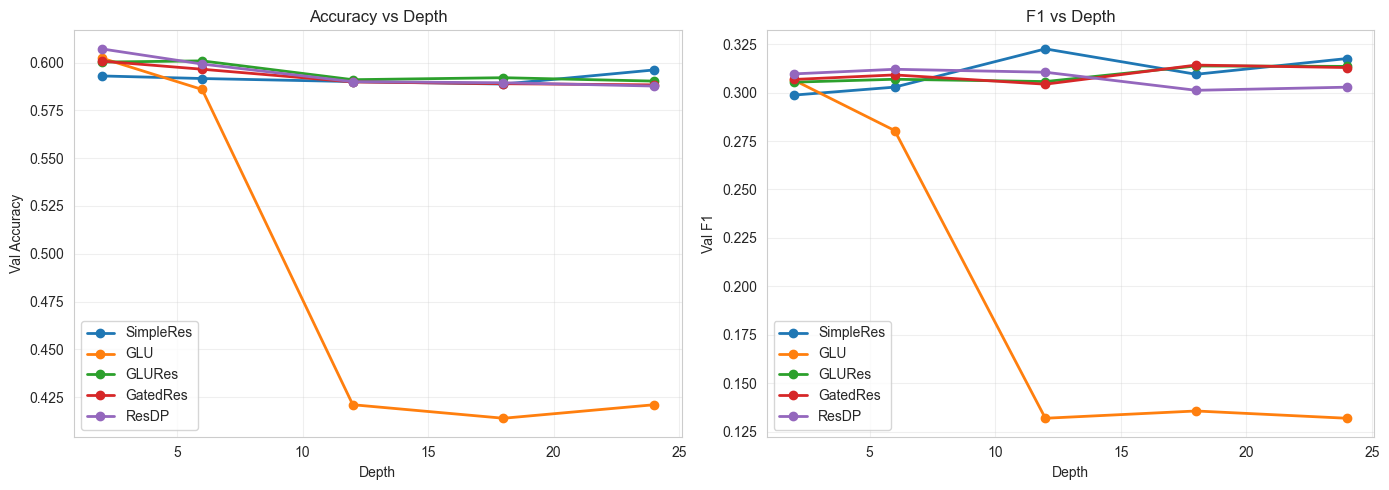

In [8]:
df = pd.DataFrame(results)
print(df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for t in df['type'].unique():
    d = df[df['type'] == t]
    axes[0].plot(d['depth'], d['val_acc'], marker='o', label=t, linewidth=2)
    axes[1].plot(d['depth'], d['val_f1'], marker='o', label=t, linewidth=2)
axes[0].set_xlabel('Depth'); axes[0].set_ylabel('Val Accuracy'); axes[0].set_title('Accuracy vs Depth'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel('Depth'); axes[1].set_ylabel('Val F1'); axes[1].set_title('F1 vs Depth'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()